# Clasificación de reseñas de películas utilizando técnicas de Procesamiento de Lenguaje Natural

## Introducción

El objetivo principal de este proyecto es desarrollar un modelo capaz de detectar automáticamente las críticas negativas de películas para Film Junky Union, una nueva y vanguardista comunidad para aficionados a las películas clásicas. Esta comunidad está creando un sistema para filtrar y categorizar reseñas de películas. Para ello, se empleará un conjunto de datos etiquetados de reseñas de películas de IMDB, con el propósito de construir un modelo de clasificación que pueda diferenciar entre reseñas positivas y negativas, alcanzando un valor F1 de al menos 0.85.

### Descripción del proyecto

El proyecto se estructura en las siguientes partes:

- __Inicialización__: Comenzar con la importación del conjunto de datos imdb_reviews.tsv y describir el conjunto de datos.

- __Preprocesamiento de datos__: Limpiar y preparar los datos para su análisis, eliminando valores duplicados y manejando valores nulos.

- __Análisis Exploratorio de Datos (EDA)__: Examinar los datos para identificar patrones, tendencias y posibles desequilibrios de clases.

- __Procedimiento de evaluación__: Crear función para evaluar el rendimiento de un modelo de clasificación utilizando diversas métricas y visualizaciones.

- __Preprocesamiento para modelado__: Limpiar las reseñas y lematizarlas.

- __Entrenamiento y evaluación de modelos__: Probar modelos de clasificación incluyendo regresión logística y potenciación del gradiente, para identificar el mejor rendimiento y evaluar los modelos entrenados en el conjunto de prueba y comparar su rendimiento.

- __Clasificación de Nuevas Reseñas__: Escribir y clasificar nuevas reseñas utilizando los modelos entrenados.

- __Conclusiones__: Síntesis de los resultados.

## Inicialización

In [60]:
# Cargar módulos
import math
import re
import spacy
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import transformers
from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from lightgbm import LGBMClassifier

from transformers import BertTokenizer, BertModel

# Mostrar una barra de progreso
tqdm.pandas()

# Mejora la calidad de las figuras
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Configura el estilo de los gráficos
plt.style.use('ggplot')

### Descripción de los datos

Los datos se almacenan en `/datasets/imdb_reviews.tsv`

Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).

Aquí se describen los campos seleccionados:

- `review`: el texto de la reseña
- `pos`: el objetivo, '0' para negativo y '1' para positivo
- `ds_part`: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

## Preporcesamiento de datos

In [2]:
# Cargar conjunto de datos
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [3]:
# Mostrar nombres de variables, tipos de datos,valores nulos y cantidad de registros
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [4]:
# Medidas descriptivas de las variables numéricas
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [5]:
# Medidas descriptivas de las variables numéricas
df_reviews.describe(include='object')

,tconst,title_type,primary_title,original_title,end_year,runtime_minutes,genres,review,sp,ds_part
count,47331,47331,47331,47331,47331,47331,47331,47331,47331,47331
unique,6648,10,6555,6562,60,249,585,47240,2,2
top,tt0099422,movie,The Sentinel,The Sentinel,\N,90,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,45052,2442,3392,5,23715,23796


In [6]:
# Revisar valores nulos en las columnas 'review', 'pos','ds_part'
df_reviews[['review', 'pos','ds_part']].isna().sum()

review     0
pos        0
ds_part    0
dtype: int64

In [7]:
# Eliminar datos duplicados en las columnas 'review', 'pos','ds_part'
df_reviews = df_reviews[~(df_reviews[['review', 'pos','ds_part']].duplicated())]

No se identificaron valores nulos en las columnas seleccionadas para el análisis (`review`, `pos`, `ds_part`), sin embargo sí se identificaron y eliminaron datos duplicados en estas columnas, lo anterior asegura que cada crítica sea única, lo que garantiza que los datos estén completos y listos para su análisis exploratorio.

## EDA

[]

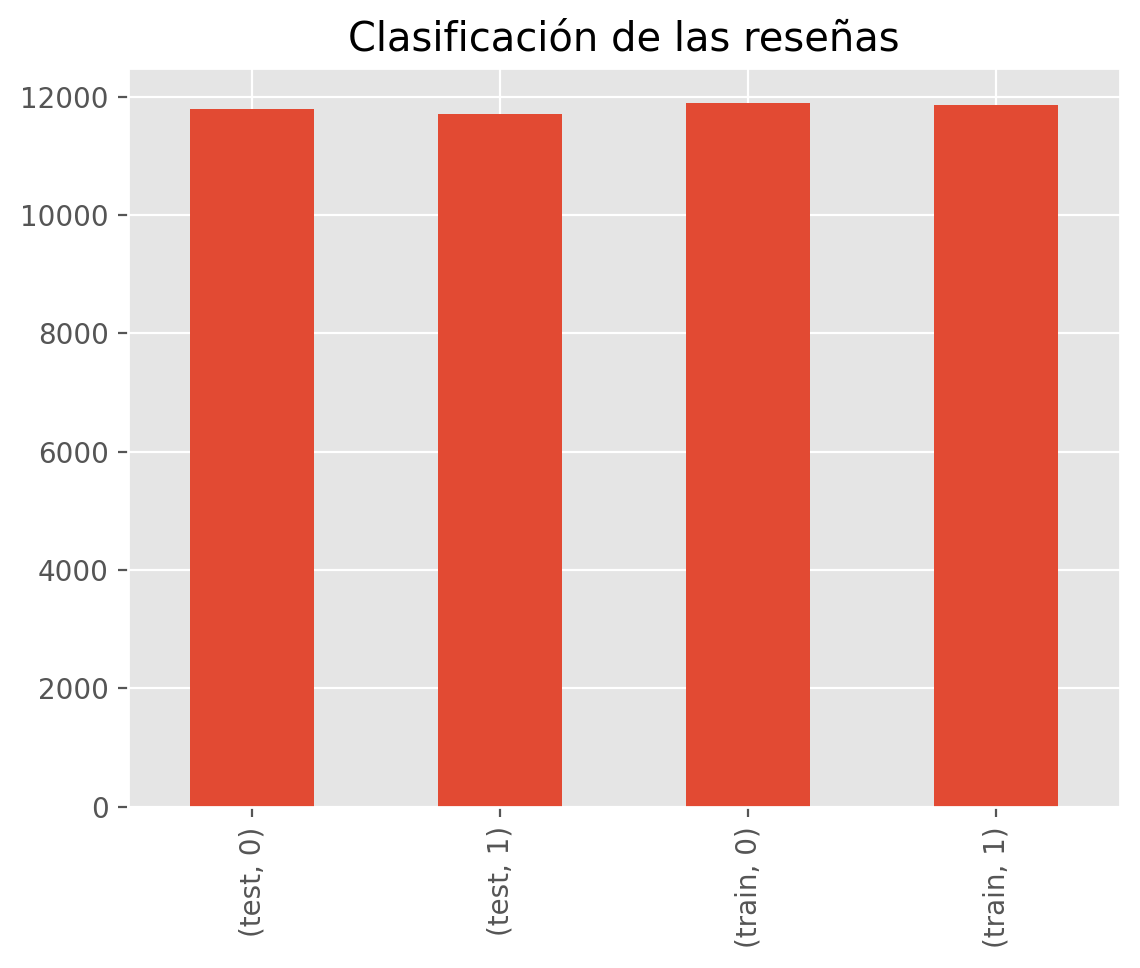

In [8]:
# Distribución de la clasificaciones de las reseñas
df_reviews[['ds_part','pos','review']]\
            .groupby(by=['ds_part','pos'])\
            .count()\
            .sort_values('ds_part')\
            .plot(kind='bar',
                 title="Clasificación de las reseñas",
                 legend=False)
plt.xlabel('')
plt.plot()

In [9]:
# Tabla de la distribución de la clasificaciones de las reseñas
df_reviews[['ds_part','pos','review']]\
            .groupby(by=['ds_part','pos'])\
            .count()\
            .sort_values('ds_part')

review
ds_part pos        
test    0     11785
        1     11698
train   0     11895
        1     11863

El gráfico muestra que la distribución de las críticas positivas y negativas en los conjuntos `train` y `test` son muy similares, así que podemos afirmar que los datos están balanceados.

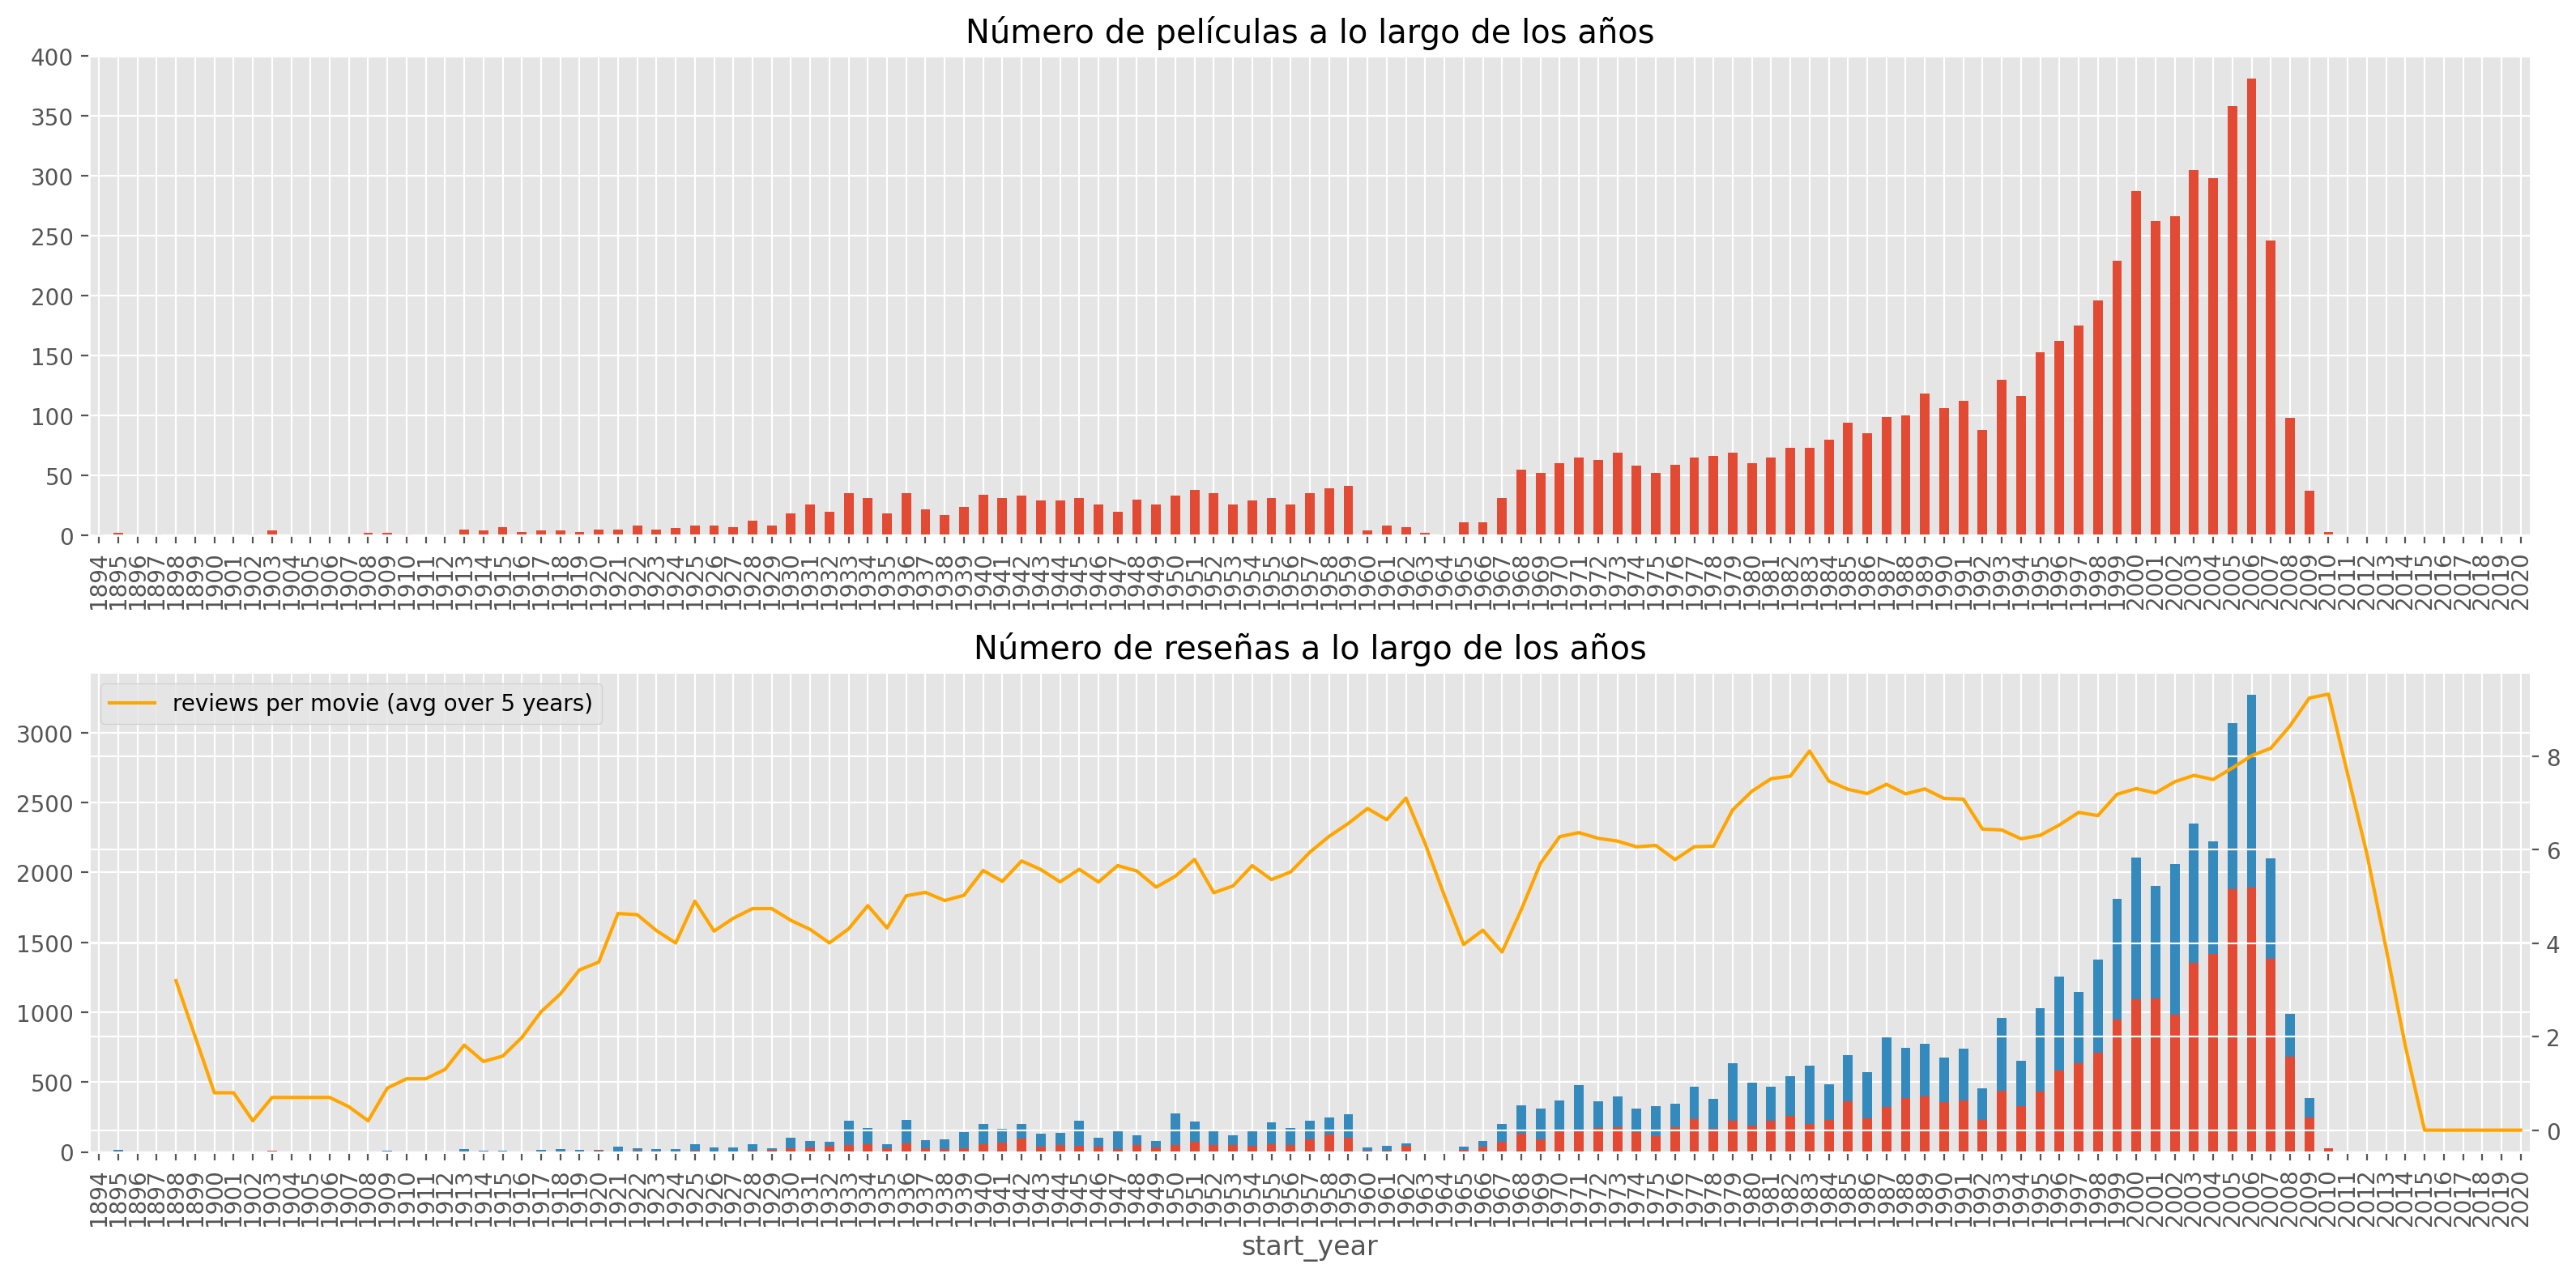

In [10]:
# Número de películas y reseñas a lo largo de los años
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Estos gráficos muestran la evolución del número de películas y reseñas a lo largo del tiempo. El primero muestra el número de películas por año, mientras que el segundo muestra el número de reseñas tanto negativas como positivas cada año. Además también se observa que en los últimos años el número de resaños ha disminuido significativamente.

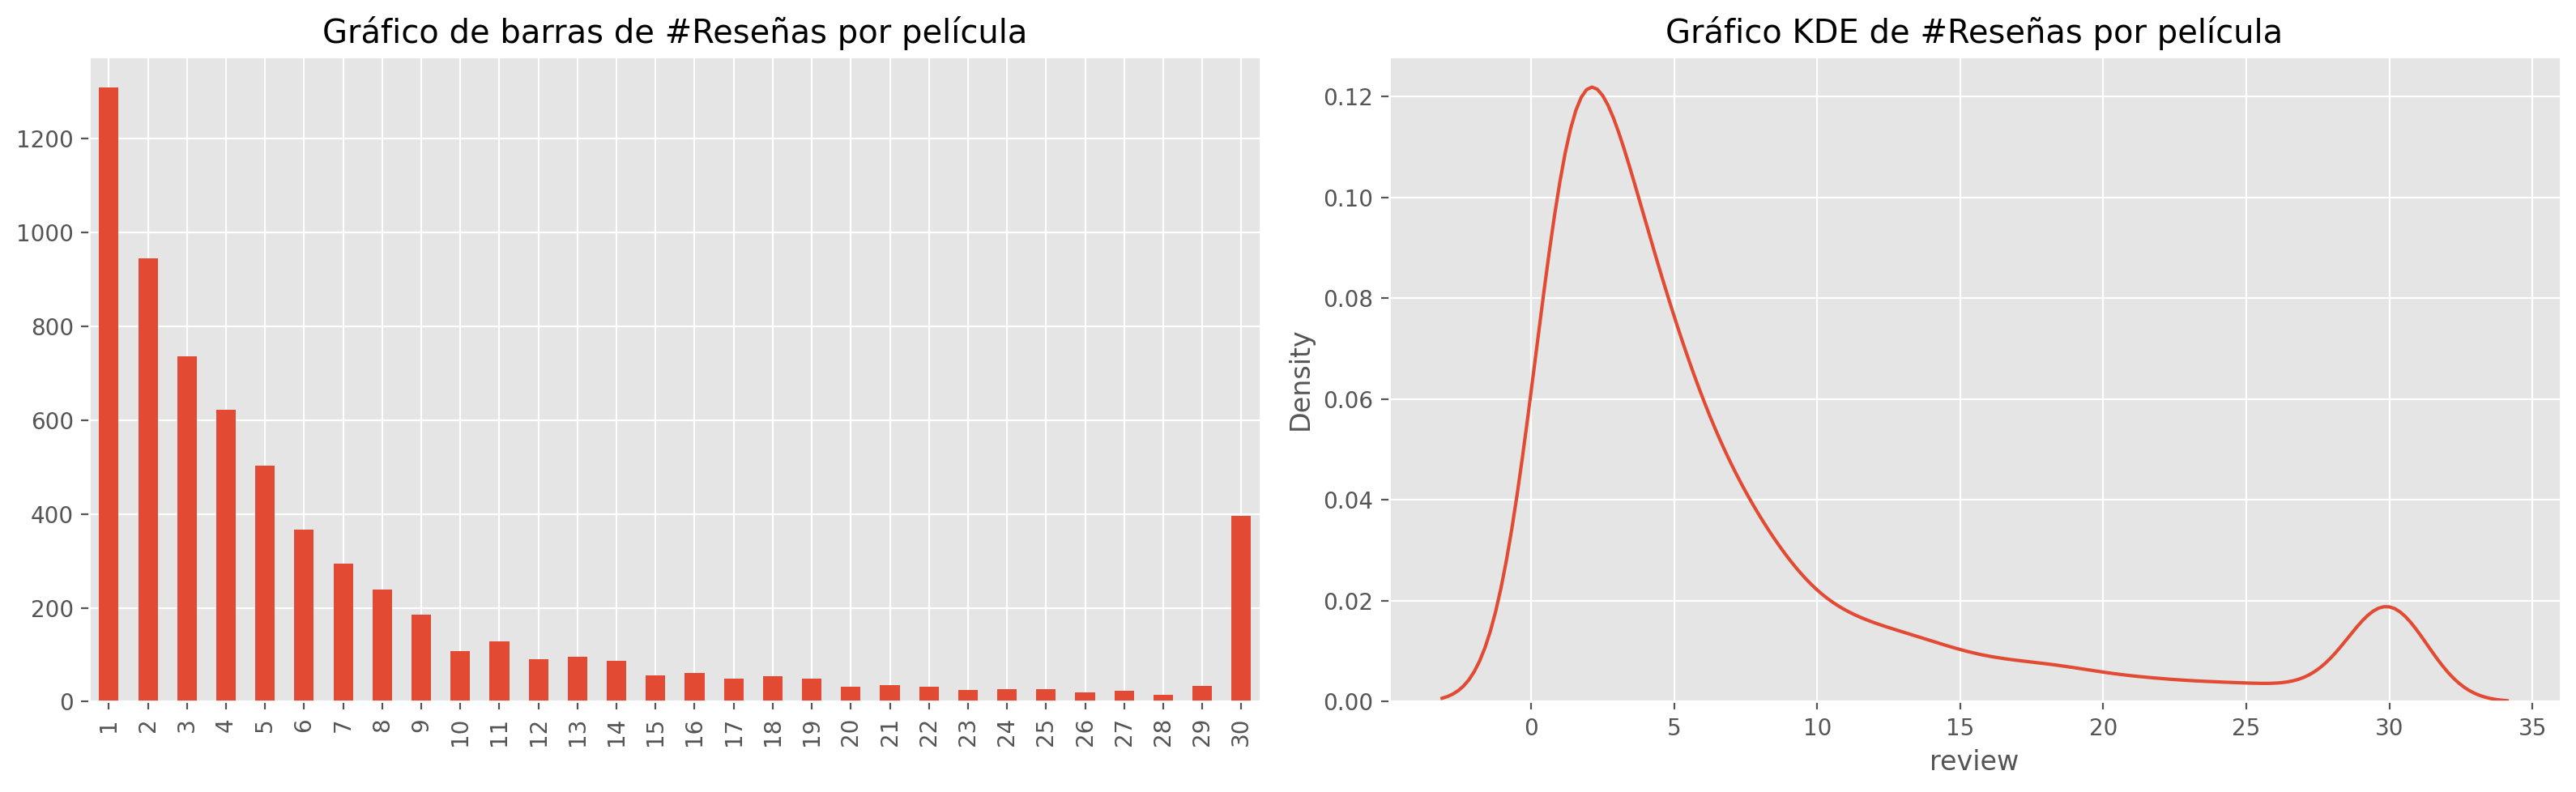

In [11]:
# Distribución del número de reseñas por película con el conteo exacto y KDE
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

El primer gráfico de barras muestra cuántas reseñas tiene cada película, al igual que el segundo grafico de densidad, denotando que lo más común es que una película tenga menos de 10 reseñas.

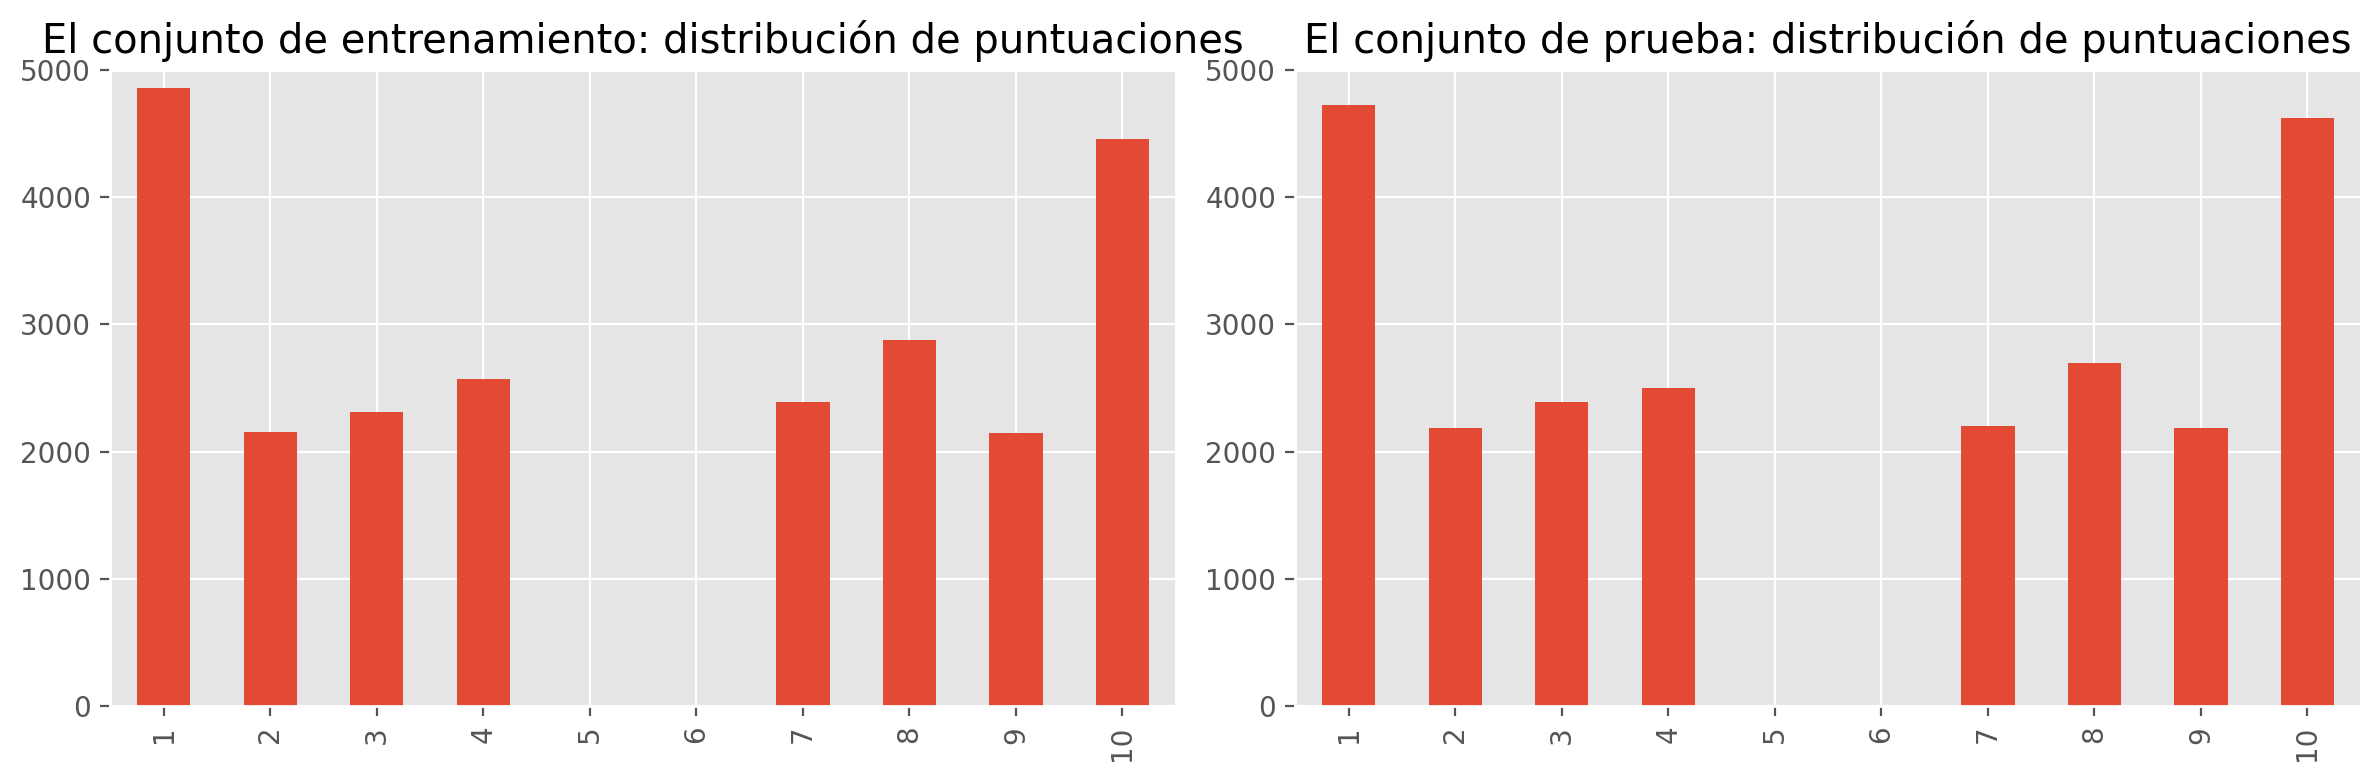

In [12]:
# Distribcuón de las puntuaciones de las películas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Estos gráficos muestran la distribución de las puntuaciones en los conjuntos de entrenamiento y prueba, debido a que las clases están balenceadas las gráficas son simétricas.


/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


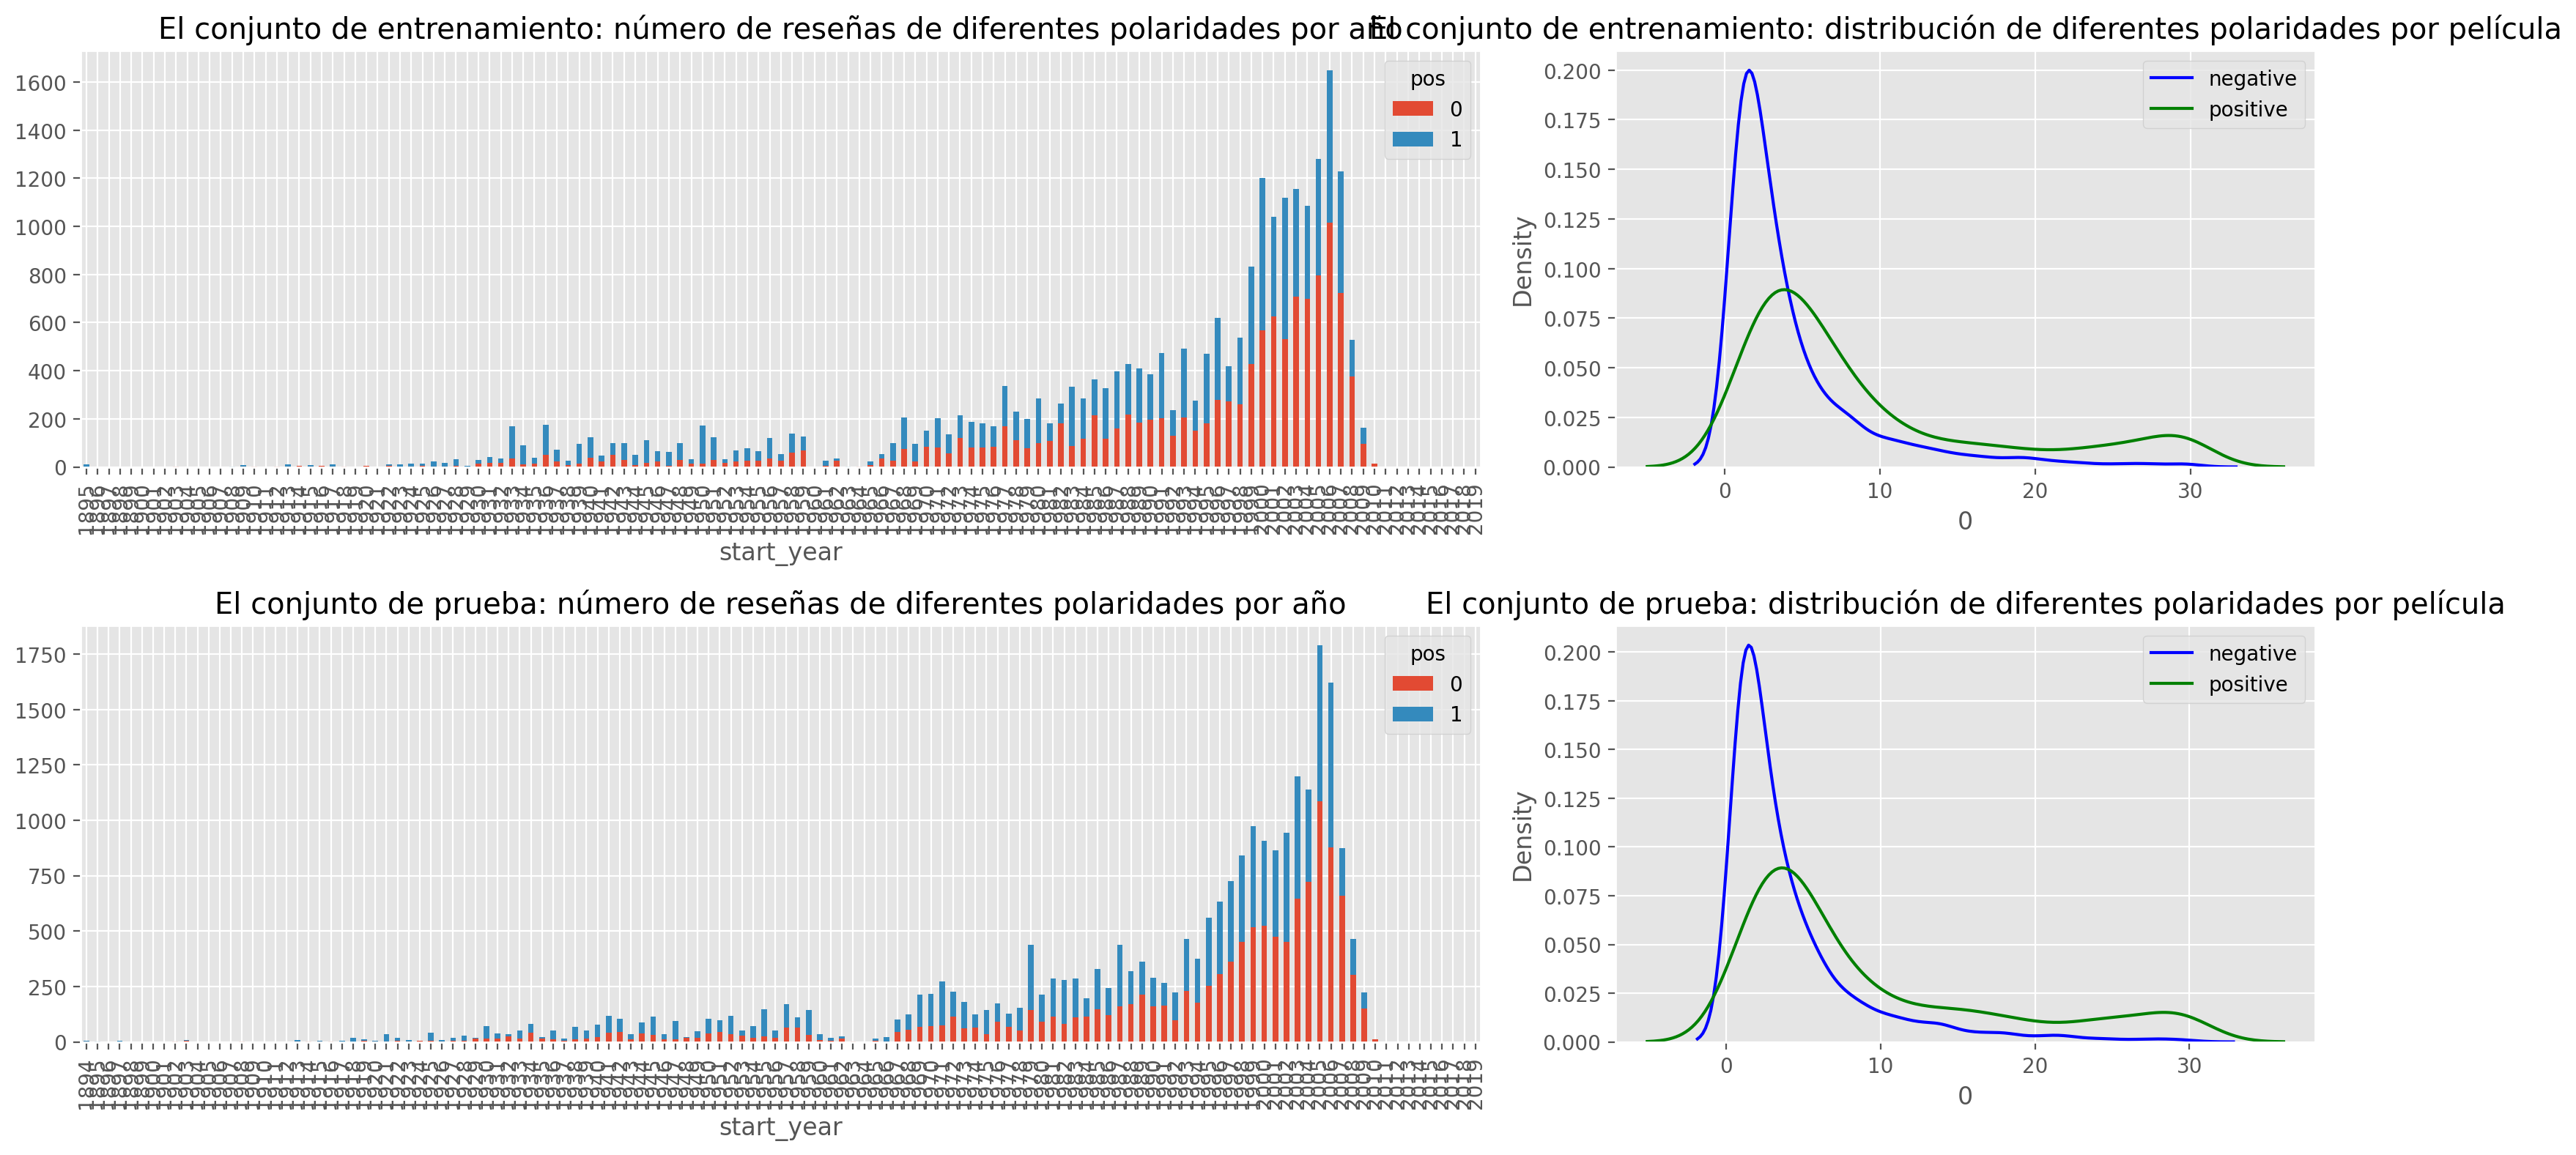

In [13]:
# Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Estos gráficos exploran cómo varía la distribución de reseñas negativas y positivas a lo largo de los años en los conjuntos de entrenamiento y prueba.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [14]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    Evalúa el rendimiento de un modelo de clasificación utilizando diversas métricas y visualizaciones.

    Parámetros:
    - model: modelo de clasificación entrenado.
    - train_features: características del conjunto de entrenamiento.
    - train_target: variable objetivo del conjunto de entrenamiento.
    - test_features: características del conjunto de prueba.
    - test_target: variable objetivo del conjunto de prueba.

    Salida:
    - Imprime un resumen de las métricas de evaluación y muestra visualizaciones.
    """

    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Preprocesamiento para el modelado

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

### Limpiar texto

In [15]:
def normalize_text(text):
    """
    Limpia un texto eliminando dígitos, convirtiendo a minúsculas y eliminando caracteres especiales.

    Parámetros:
    - text (str): Texto que se desea normalizar.

    Salida:
    - Texto sin dígitos ni caracteres especiales, convertido a minúsculas.

    """
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar dígitos
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales
    text = " ".join(text.split())  # Eliminar espacios adicionales
    return text

In [16]:
# Aplicar la función a las reseñas
df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_text)

# Mostrar la primera filas para verificar
df_reviews[['review', 'review_norm']].head(1)

  0%|          | 0/47241 [00:00<?, ?it/s]

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...


### Lematización

In [17]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(text):
    """
    Realiza la lematización de un texto utilizando Spacy.

    Parámetros:
    - text (str): Texto que se desea lematizar.

    Salida:
    - Texto lematizado
    """
    
    doc = nlp(text)

    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [18]:
# Aplicar la función a las reseñas
df_reviews['review_lemmatize'] = df_reviews['review_norm'].progress_apply(lemmatize)

# Mostrar las primera filas para verifica
df_reviews[['review_norm', 'review_lemmatize']].head(1)

  0%|          | 0/47241 [00:00<?, ?it/s]

,review_norm,review_lemmatize
0,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...


In [19]:
# Comparar reseña original, normalizada y lematizada
df_reviews[['review','review_norm', 'review_lemmatize']].head(1)

,review,review_norm,review_lemmatize
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...


## Entrenamiento y evaluación de modelos

### División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [20]:
# Separar los datos de entrenamiento y prueba según la columna 'ds_part'
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Extraer la variable objetivo para los conjuntos 
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23758, 19)
(23483, 19)


### Modelo 0 - Constante

In [21]:
# División de datos para el Modelo 0 - Constante
train_texts_0 = df_reviews_train['review_norm']
test_texts_0 = df_reviews_test['review_norm']

           train  test
Exactitud   0.50  0.50
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


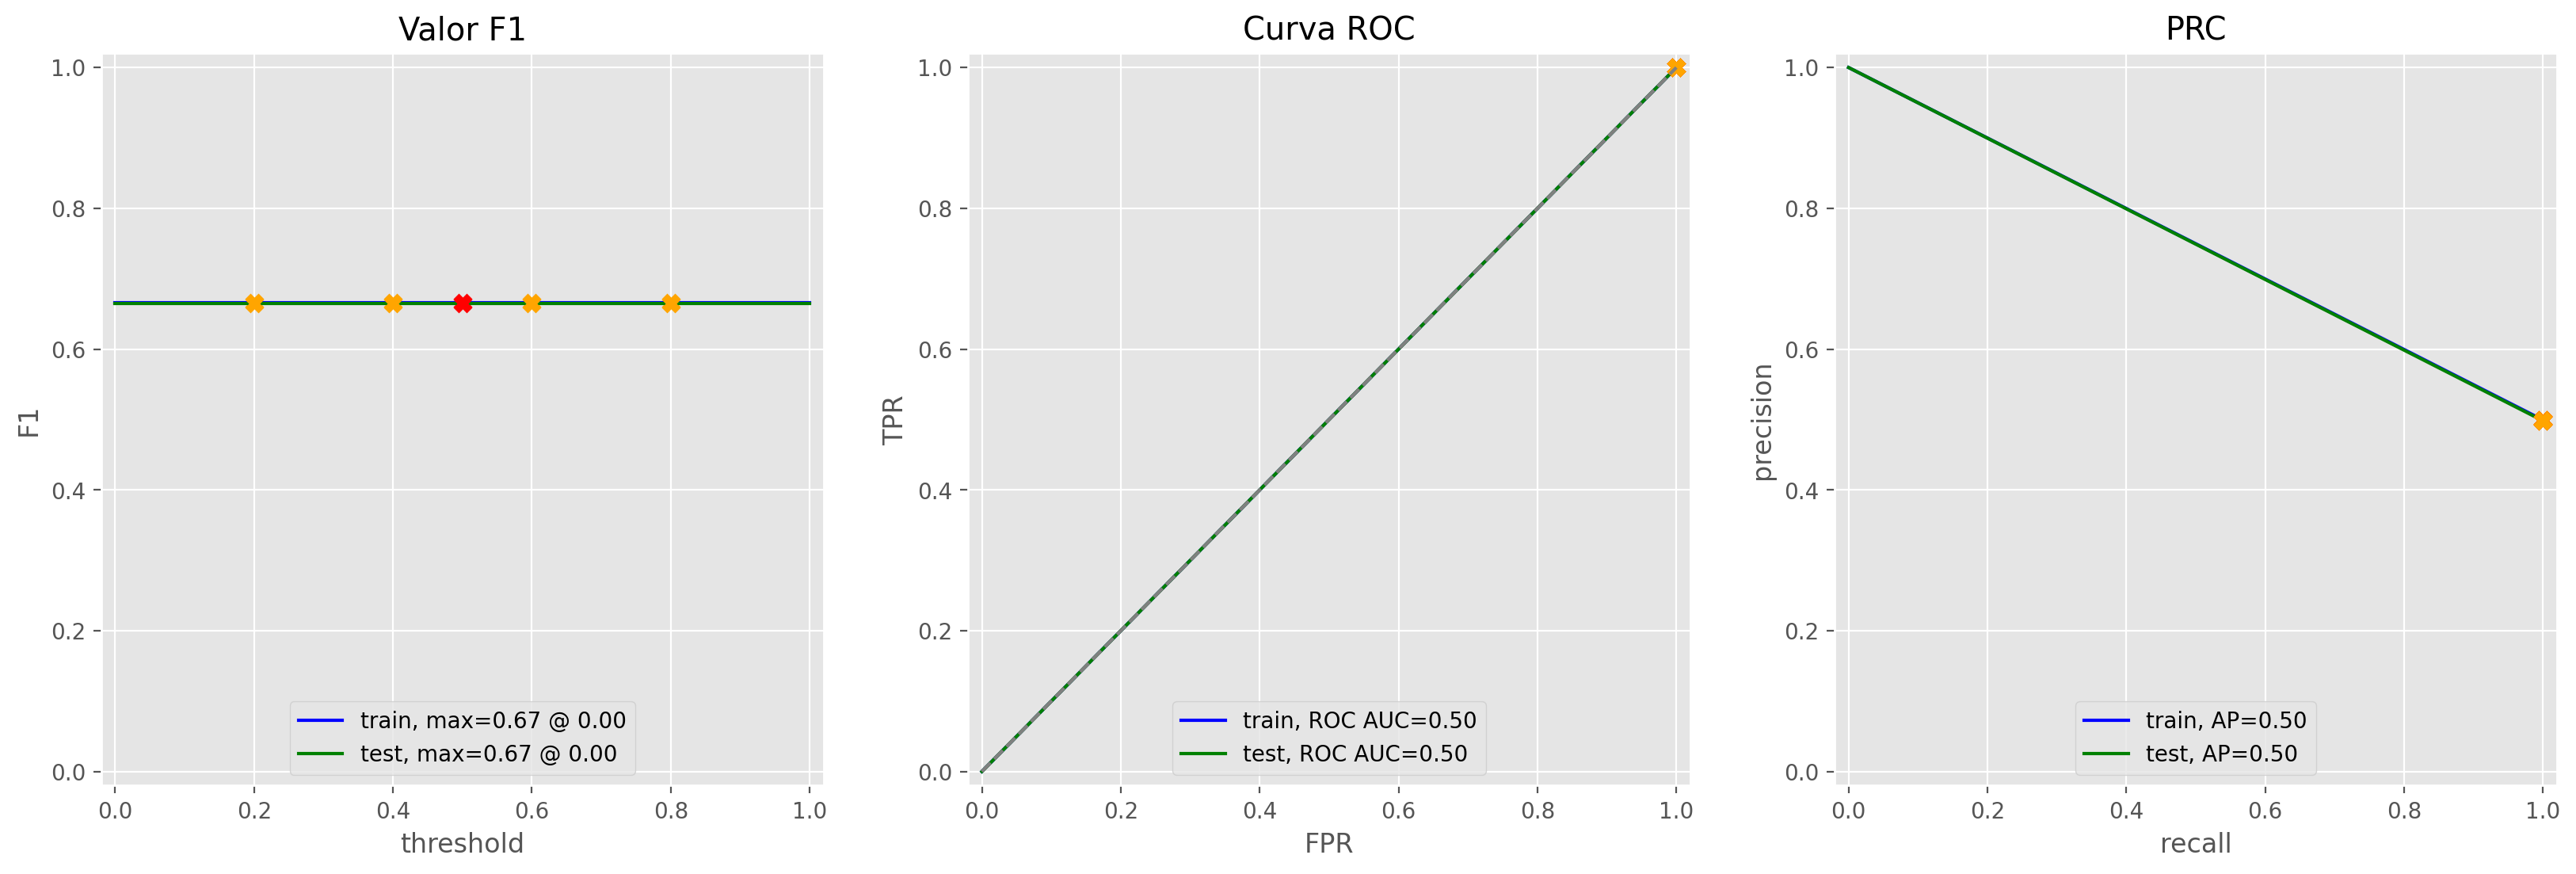

In [22]:
# Creación y entrenamiento del modelo DummyClassifier
model_0 = DummyClassifier(strategy='constant', constant=1)
model_0.fit(train_texts_0, train_target)

# Evaluación del modelo DummyClassifier llamando a la función 'evaluate_model'
evaluate_model(model_0, train_texts_0, train_target, test_texts_0, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [23]:
def lemmatize_nlkt(text):
    
    """
    Esta función devuelve una versión lematizada de un texto

    Parámetros:
   
    - text : El texto de entrada que se va a lematizar.


    Devuelve: El texto lematizado.
    """
    
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    
    return " ".join(lemmas)

In [24]:
# División de datos para el Modelo 1 - NLTK, TF-IDF y LR
train_texts_1 = df_reviews_train['review_norm'].progress_apply(lemmatize_nlkt)
test_texts_1 = df_reviews_test['review_norm'].progress_apply(lemmatize_nlkt)

  0%|          | 0/23758 [00:00<?, ?it/s]

  0%|          | 0/23483 [00:00<?, ?it/s]

In [50]:
# Crear una instancia de TfidfVectorizer con stopwords
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words = stop_words)

# Transformar el conjunto de entrenamiento a una representación TF-IDF
train_features_1 = tfidf_vectorizer_1.fit_transform(train_texts_1)

# Transformar el conjunto de prueba a la misma representación TF-IDF
test_features_1 = tfidf_vectorizer_1.transform(test_texts_1)

In [26]:
# %%time

# # Definir la búsqueda de hiperparámetros para Regresión Logística
# parameters = {
#     'penalty' : ['l1','l2'], 
#     'solver'  : ['liblinear', 'saga'],
#     'C'       : [0.1, 1.0],
#     'fit_intercept':[True, False]
# }

# # Realizamos la búsqueda de hiperparámetros
# nltk_lr = GridSearchCV(LogisticRegression(random_state=12345),
#                       param_grid=parameters,
#                       scoring='f1',
#                       cv=3
#                       )

# # Entrenamos el modelo 
# nltk_lr.fit(train_features_1, train_target)

In [27]:
# # Mostramos los mejores parámetros encontrados
# best_params_1 = nltk_lr.best_params_
# best_f1_1 = nltk_lr.best_score_
# print(f'Mejores hiperparámetros: {best_params_1} | Mejor f1: {best_f1_1:.4f}')

           train  test
Exactitud   0.94  0.88
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


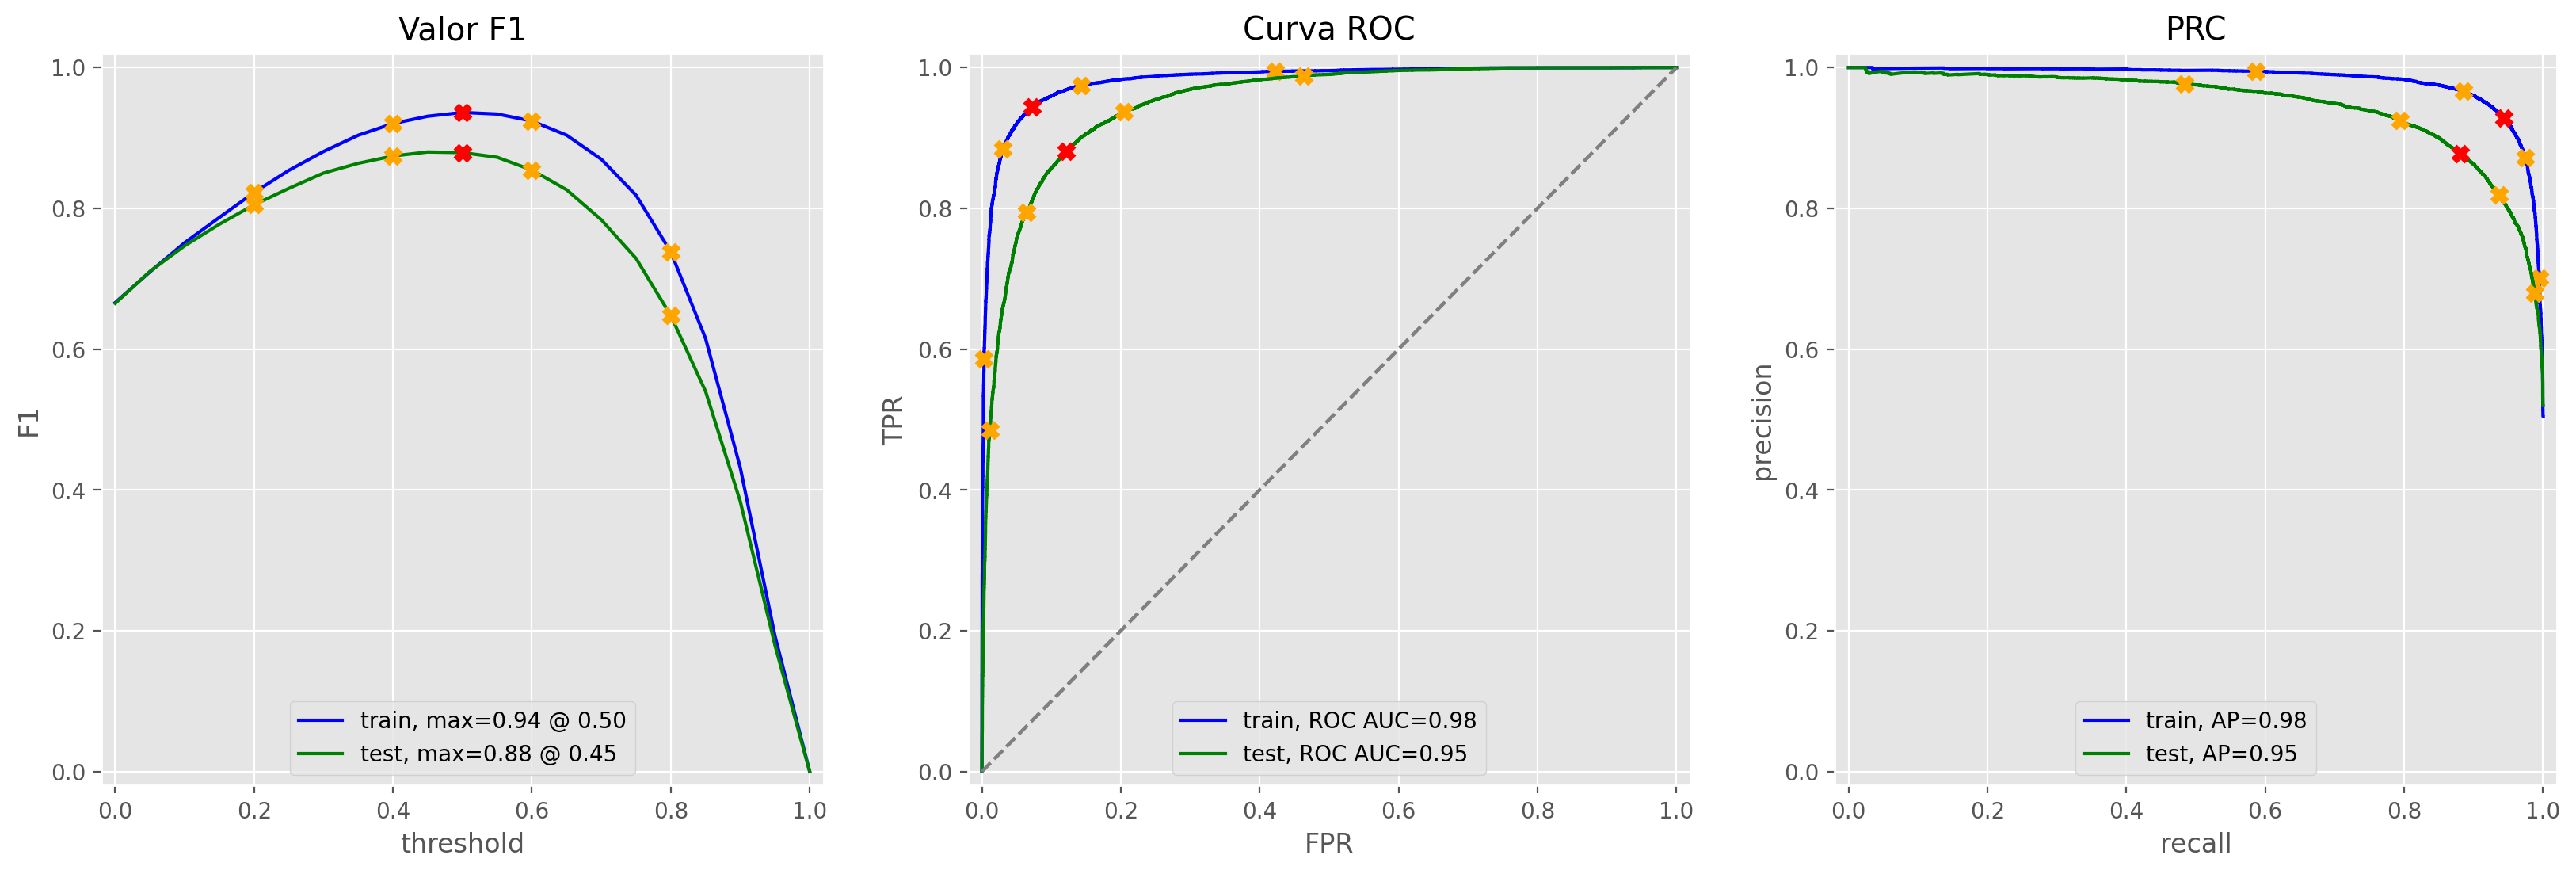

In [28]:
# Entrenamos nuestro primer modelo con los mejores hiperparámetros
model_1 = LogisticRegression(random_state=12345, solver='liblinear', penalty= 'l2', C= 1.0, fit_intercept=False)
model_1.fit(train_features_1, train_target)

# Evaluamos el modelo en el conjunto de prueba a través de la función evaluate_model
evaluate_model_1 = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)
evaluate_model_1

### Modelo 3 - spaCy, TF-IDF y LR

In [29]:
# División de datos para el Modelo 3 - spaCy, TF-IDF y LR
train_texts_3 = df_reviews_train['review_lemmatize']
test_texts_3 = df_reviews_test['review_lemmatize']

In [52]:
# Crear una instancia de TfidfVectorizer con stopwords
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words = stop_words)

# Transformar el conjunto de entrenamiento a una representación TF-IDF
train_features_3 = tfidf_vectorizer_3.fit_transform(train_texts_3)

# Transformar el conjunto de prueba a la misma representación TF-IDF
test_features_3 = tfidf_vectorizer_3.transform(test_texts_3)

In [31]:
# %%time

# # Definir la búsqueda de hiperparámetros para Regresión Logística
# parameters = {
#     'penalty' : ['l1','l2'], 
#     'solver'  : ['liblinear', 'saga'],
#     'C'       : [0.1, 1.0],
#     'fit_intercept':[True, False]
# }

# # Realizamos la búsqueda de hiperparámetros
# spacy_lr = GridSearchCV(LogisticRegression(random_state=12345),
#                       param_grid=parameters,
#                       scoring='f1',
#                       cv=3
#                       )

# # Entrenamos el modelo 
# spacy_lr.fit(train_features_3, train_target)


In [32]:
# # Mostramos los mejores parámetros encontrados
# best_params_3 = spacy_lr.best_params_
# best_f1_3 = spacy_lr.best_score_
# print(f'Mejores hiperparámetros: {best_params_3} | Mejor f1: {best_f1_3:.4f}')

           train  test
Exactitud   0.93  0.88
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


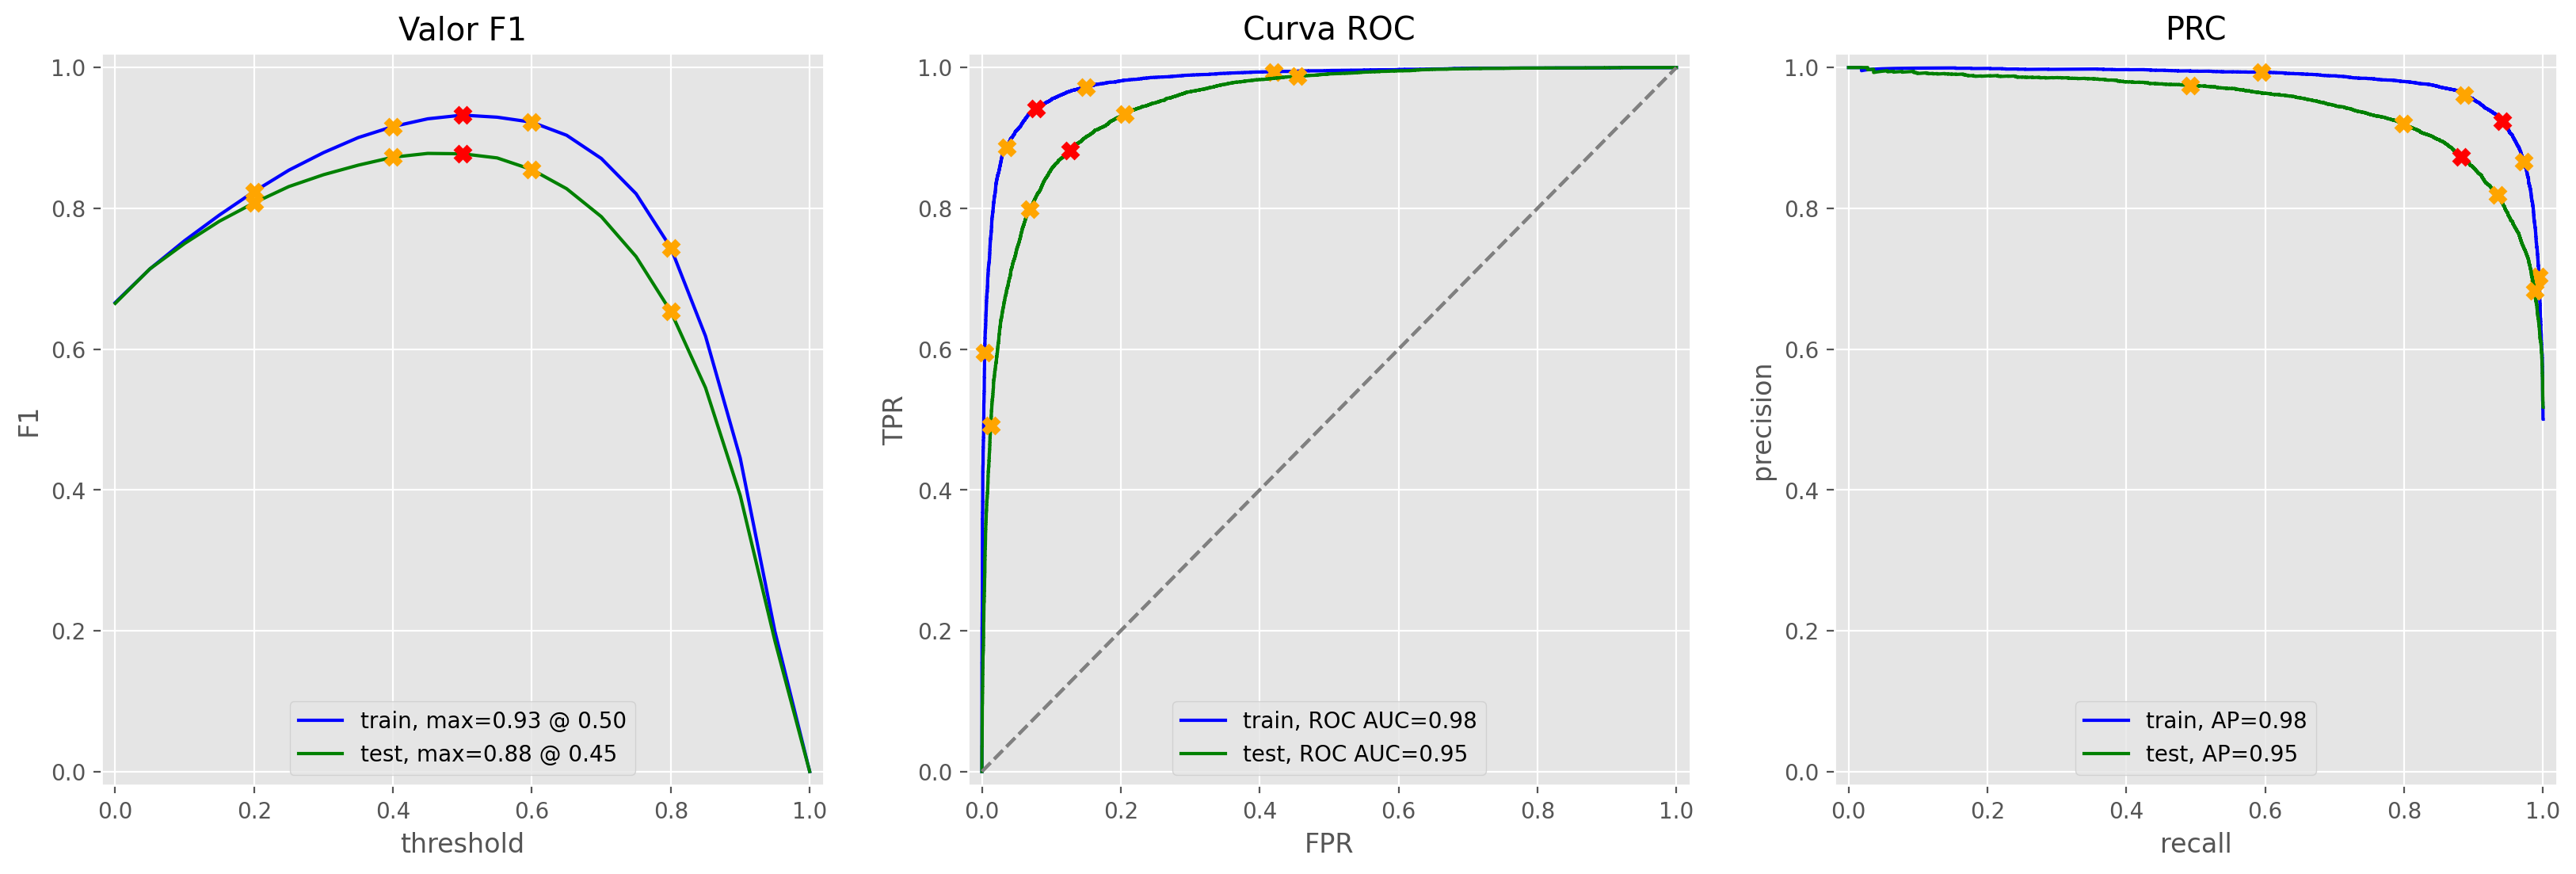

In [33]:
# Entrenamos el modelo con los mejores hiperparámetros
model_3 = LogisticRegression(random_state=12345, solver='liblinear', penalty= 'l2', C= 1.0, fit_intercept=False)
model_3.fit(train_features_3, train_target)

# Evaluamos el modelo en el conjunto de prueba a través de la función evaluate_model
evaluate_model_3 = evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)
evaluate_model_3

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [34]:
# División de datos para el Modelo 4 - spaCy, TF-IDF y LGBMClassifier
train_texts_4 = df_reviews_train['review_lemmatize']
test_texts_4 = df_reviews_test['review_lemmatize']

In [54]:
# Crear una instancia de TfidfVectorizer con stopwords
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_4 = TfidfVectorizer(stop_words = stop_words)

# Transformar el conjunto de entrenamiento a una representación TF-IDF
train_features_4 = tfidf_vectorizer_4.fit_transform(train_texts_4)

# Transformar el conjunto de prueba a la misma representación TF-IDF
test_features_4 = tfidf_vectorizer_4.transform(test_texts_4)

In [36]:
# %%time

# # Definir la búsqueda de hiperparámetros para LightGBM
# parameters_lightgbm = {
#     'objective': ['binary'],
#     'num_leaves': [31, 40],
#     'learning_rate': [0.1, 0.2]
# }

# # Realizar la búsqueda de hiperparámetros
# spacy_lightgbm = GridSearchCV(
#     LGBMClassifier(random_state=12345),
#     param_grid=parameters_lightgbm,
#     scoring='f1',
#     cv=3
# )

# # Entrenar el modelo
# spacy_lightgbm.fit(train_features_4, train_target)


In [37]:
# # Mostramos los mejores parámetros encontrados
# best_params_4 = spacy_lightgbm.best_params_
# best_f1_4 = spacy_lightgbm.best_score_
# print(f'Mejores hiperparámetros: {best_params_4} | Mejor f1: {best_f1_4:.4f}')

           train  test
Exactitud   0.97  0.87
F1          0.97  0.87
APS         1.00  0.94
ROC AUC     1.00  0.94


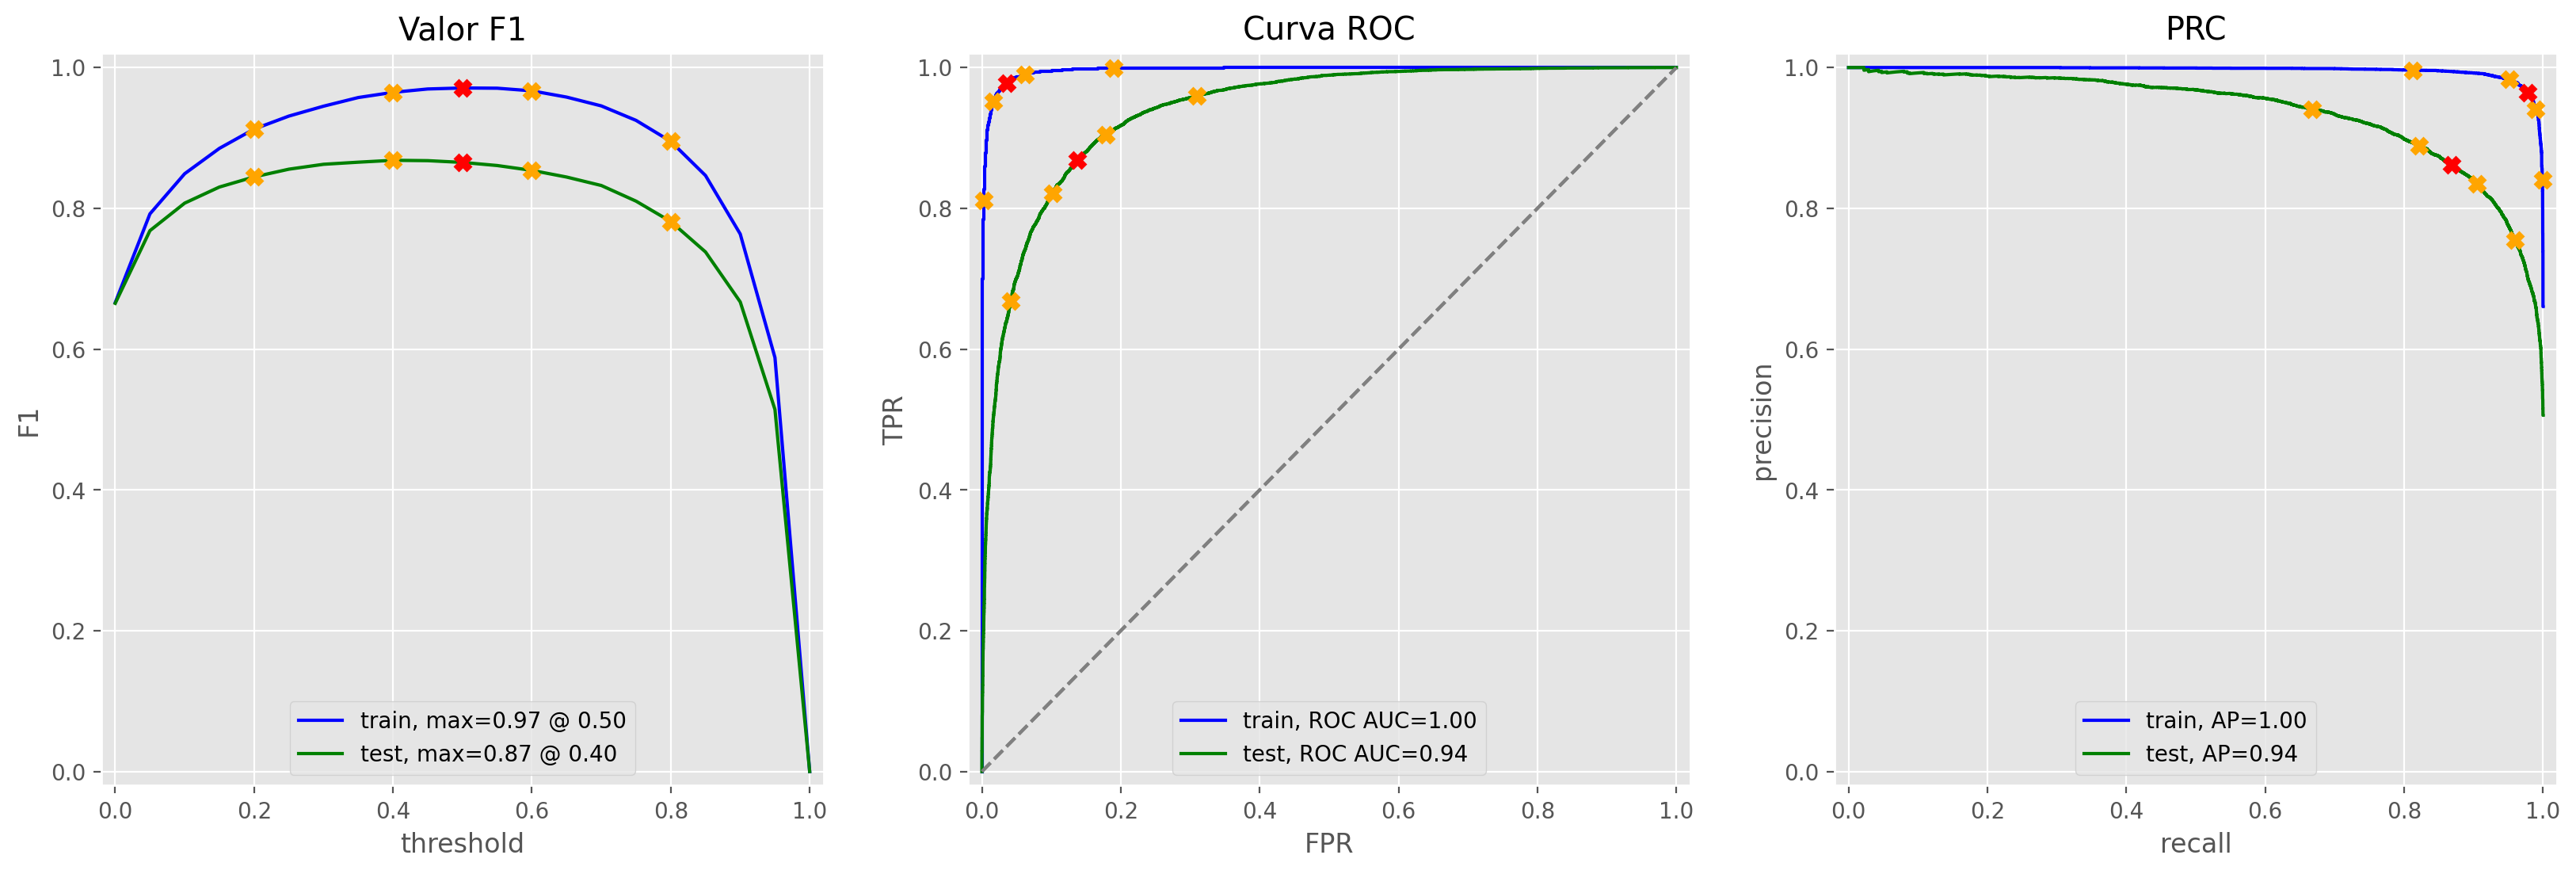

In [38]:
# Mejores hiperparámetros a nuestro modelo LGMBClassifier
model_4 = LGBMClassifier(learning_rate=0.2,
                             num_leaves=40, 
                             objective='binary',
                             random_state=12345)

# Entrenamos el modelo 
model_4.fit(train_features_4, train_target)

# Evaluamos el rendimiento del modelo con la función 'evalute_model'
evaluate_model_4 = evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)
evaluate_model_4

###  Modelo 9 - BERT

El modelo 9 se ejecutó en Google Colab. Por lo anterior, se comparto liga del Jupyther notebook: https://colab.research.google.com/drive/1byVzYpfBQMT0TGw7DAyiXOs5B2obEaLV?usp=sharing

In [39]:
# # Importamos el tokenizador de BERT, cargamos la configuración y el modelo preentrenado
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [40]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
#     """
#     Convierte una lista de textos en embeddings utilizando el modelo BERT.
    
#     Parámetros:
    
#     - texts : Lista de textos.
    
#     - max_length : Longitud máxima de los textos
    
#     - batch_size : Número de textos a procesar por lote
    
#     - force_device : Dispositivo a utilizar ('cuda','cpu' )
    
#     - disable_progress_bar : Desactiva la barra de progreso
    
#     Salida: Matriz de embeddings generados por BERT

#     """
    
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     model = BertModel.from_pretrained('bert-base-uncased')

#     ids_list = []
#     attention_mask_list = []

#     for text in texts:
#         encoded_dict = tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=max_length,
#             pad_to_max_length=True,
#             return_attention_mask=True,
#             return_tensors='pt',
#         )
#         ids_list.append(encoded_dict['input_ids'])
#         attention_mask_list.append(encoded_dict['attention_mask'])

#     ids_list = torch.cat(ids_list, dim=0).numpy()
#     attention_mask_list = torch.cat(attention_mask_list, dim=0).numpy()

#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Uso del dispositivo {device}.')

#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
#         ids_batch = torch.LongTensor(ids_list[batch_size * i:batch_size * (i + 1)]).to(device)
#         attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)

#         with torch.no_grad():
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
#             embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

#     return np.concatenate(embeddings)

In [41]:
# # División de datos para el Modelo 9 - BERT, LGBM
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
# test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

In [42]:
# # Guardar los insertados
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [43]:
# # Cargar los insertados
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [44]:
# %%time 

# # Definir la búsqueda de hiperparámetros para LightGBM
# params_lgbm_bert = {
#     'objective' : ['binary'], 
#     'num_leaves': [31, 40],
#     'learning_rate': [0.1, 0.2]
# }

# # Realizamos la búsqueda de hiperparámetros
# bert_lightgbm = GridSearchCV(LGBMClassifier(random_state=12345),
#                        param_grid=params_lgbm_bert,
#                        scoring='f1',
#                        cv=3
#                     )

# # Entrenamos el modelo 
# bert_lightgbm.fit(train_features_9, train_target)

In [45]:
# # Mostramos los mejores parámetros encontrados
# best_params_9 = bert_lightgbm.best_params_
# best_f1_9 = bert_lightgbm.best_score_
# print(f'Mejores hiperparámetros: {best_params_9} | Mejor f1: {best_f1_9:.4f}')

In [71]:
# # Mejores hiperparámetros a nuestro modelo LGMBClassifier
# model_9 = LGBMClassifier(learning_rate=0.2,
#                              num_leaves=40, 
#                              objective='binary',
#                              random_state=12345)

# # Entrenamos el modelo 
# model_9.fit(train_features_9, train_target)

# # Evaluamos el rendimiento del modelo con la función 'evalute_model'
# evaluate_model_9 = evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)
# evaluate_model_9

|          |train|  test|
|----------|-----|------|
|Exactitud|   0.99|  0.83|
|F1        |  0.99|  0.83|
|APS         |1.00|  0.91|
|ROC AUC     |1.00|  0.91|

Los modelos 1 y 3 muestran un equilibrio entre el rendimiento en los datos de entrenamiento y prueba, con puntuaciones F1 de 0.94 y 0.88 respectivamente.En ambos se utilizan TF-IDF y regresión logística, con diferentes enfoques de lematización.

## Clasificacion de nuevas reseñas

In [47]:
# Crear un DataFrame con ejemplos de nuevas reseñas para clasificar
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].progress_apply(normalize_text)
my_reviews['review_lemmatize_nlkt'] = my_reviews['review_norm'].progress_apply(lemmatize_nlkt)
my_reviews['review_lemmatize'] = my_reviews['review_norm'].progress_apply(lemmatize)
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

my_reviews

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

,review,review_norm,review_lemmatize_nlkt,review_lemmatize,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,i did not simply like it not my kind of movie,I do not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,well i wa bored and felt asleep in the middle ...,well I be bored and feel asleep in the middle ...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,i wa really fascinated with the movie,I be really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,even the actor looked really old and disintere...,even the actor look really old and disinterest...,0
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...,i didnt expect the reboot to be so good writer...,I do not expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,the movie had it upside and downside but i fee...,the movie have its upside and downside but I f...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,launching on netflix wa a brave move i really ...,launch on netflix be a brave move I really app...,1


### Modelo 1 - NLTK, TF-IDF y LR

In [51]:
# Predecir clasificación de las nuevas reseñas
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  i did not simply like it not my kind of movie
0.21:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.33:  i didnt expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [64]:
# Calcular métrica f1
y_true = my_reviews['pos']
y_pred = model_1.predict(tfidf_vectorizer_1.transform(texts))
f1_score_model_1 = f1_score(y_true, y_pred)
f1_score_model_1

0.8571428571428571

### Modelo 3 - spaCy, TF-IDF y LR

In [53]:
# Predecir clasificación de las nuevas reseñas
texts = my_reviews['review_lemmatize']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  I do not simply like it not my kind of movie
0.13:  well I be bored and feel asleep in the middle of the movie
0.51:  I be really fascinated with the movie
0.10:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.28:  I do not expect the reboot to be so good writer really care about the source material
0.48:  the movie have its upside and downside but I feel like overall its a decent flick I could see myself
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.93:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


In [65]:
# Calcular métrica f1
y_pred = model_3.predict(tfidf_vectorizer_3.transform(texts))
f1_score_model_3 = f1_score(y_true, y_pred)
f1_score_model_3

0.6666666666666666

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [55]:
# Predecir clasificación de las nuevas reseñas
texts = my_reviews['review_lemmatize']

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  I do not simply like it not my kind of movie
0.18:  well I be bored and feel asleep in the middle of the movie
0.59:  I be really fascinated with the movie
0.17:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.53:  I do not expect the reboot to be so good writer really care about the source material
0.72:  the movie have its upside and downside but I feel like overall its a decent flick I could see myself
0.13:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.88:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


In [66]:
# Calcular métrica f1
y_pred = model_4.predict(tfidf_vectorizer_4.transform(texts))
f1_score_model_4 = f1_score(y_true, y_pred)
f1_score_model_4

0.888888888888889

### Modelo 9

In [ ]:
# # Predecir clasificación de las nuevas reseñas
# texts = my_reviews['review_norm']

# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  i did not simply like it not my kind of movie

0.05:  well i was bored and felt asleep in the middle of the movie

0.61:  i was really fascinated with the movie

0.04:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul

0.31:  i didnt expect the reboot to be so good writers really cared about the source material

0.96:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel

0.01:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 

0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo

In [ ]:
# Calcular métrica f1
# y_pred = model_9.predict(my_reviews_features_9)
# f1_score_model_9 = f1_score(y_true, y_pred)
# f1_score_model_9

In [70]:
f1_score_model_9 = 0.75

En este caso el modelo 4 (spaCy, TF-IDF y LGBMClassifier) demostró ser el más efectivo en la clasificación de nuevas reseñas de películas, con un valor F1 de 0.8889.

## Conclusiones

-  Se verificó que los datos estaban balanceados en términos de reseñas positivas y negativas, lo cual implica que los modelos no estén sesgados.

- Se observó que el número de películas y reseñas ha disminuido en los últimos años, lo cual puede interpretarse que hay poco interés por los usarios por las películas nuevas.

- De los modelos evaluados para la clasificación de nuevas reseñas, el Modelo 4 (lematización con spaCy, TF-IDF y LGBMClassifier) resultó ser el mejor, obteniende un valor F1 de 0.8889, alcanzando el umbral de la métrica de 0.85. Este modelo demostró ser el más preciso y capaz de generalizar mejor en la clasificación de nuevas reseñas de películas.

- Por lo anterior, en este proyecto se demostró la eficacia de diversas técnicas de PLN y aprendizaje automático en la clasificación de reseñas.
